# Script - B2W Challenge - Lucas Edler

## 1) Pré processamento dos dados

Importando bibliotecas

In [1]:
comp_prices<-read.csv("comp_prices.csv", sep = ",")
sales<-read.csv("sales.csv")

Cria conceito de preço unitário

In [2]:
sales$UNITARY_PRICE<-sales$REVENUE / sales$QTY_ORDER

Tratamento de dados: tabela comp_prices parece ter erros de input (alguns dados parecem estar multiplicados *100)

In [3]:
comp_prices_aux<-comp_prices[,c("COMPETITOR_PRICE","PROD_ID","DATE_EXTRACTION","COMPETITOR", "PAY_TYPE")]
names(comp_prices_aux)<-c("UNITARY_PRICE","PROD_ID","DATE_ORDER","SELLER","PAY_TYPE")
comp_prices_aux$UNITARY_PRICE<-ifelse(comp_prices_aux$UNITARY_PRICE>3000,comp_prices_aux$UNITARY_PRICE/100,comp_prices_aux$UNITARY_PRICE)

# 2) Modelagem

Produto 3 (P3)

In [4]:
sales_P<-sales[sales$PROD_ID=="P3",c("DATE_ORDER","QTY_ORDER","UNITARY_PRICE")]

Criando matriz com dia, quantidade vendidade e preço médio de venda

In [5]:
aux<-aggregate(sales_P$UNITARY_PRICE, by = list(sales_P$DATE_ORDER), FUN = mean)
sales_P<-aggregate(sales_P$QTY_ORDER, by = list(sales_P$DATE_ORDER), FUN = sum)
sales_P<-merge(sales_P,aux,by = "Group.1", all.x = TRUE)

Enriquecendo matriz com a informação do preço mínimo da concorrência

Pay type = 1 (vendas a prazo)

In [6]:
comp_prices_P_M1<-comp_prices_aux[comp_prices_aux$PROD_ID=="P3" & comp_prices_aux$PAY_TYPE==1,c("DATE_ORDER","UNITARY_PRICE")]
comp_prices_P_M1$DATE_ORDER<-as.Date(comp_prices_P_M1$DATE_ORDER)
comp_prices_P_M1$DATE_ORDER<-as.factor(comp_prices_P_M1$DATE_ORDER)
aux<-aggregate(comp_prices_P_M1$UNITARY_PRICE, by = list(comp_prices_P_M1$DATE_ORDER), FUN = min)
sales_P<-merge(sales_P,aux,by = "Group.1", all.x = TRUE)

Pay type = 2 (vendas a vista)

In [7]:
comp_prices_P_M2<-comp_prices_aux[comp_prices_aux$PROD_ID=="P3" & comp_prices_aux$PAY_TYPE==2,c("DATE_ORDER","UNITARY_PRICE")]
comp_prices_P_M2$DATE_ORDER<-as.Date(comp_prices_P_M2$DATE_ORDER)
comp_prices_P_M2$DATE_ORDER<-as.factor(comp_prices_P_M2$DATE_ORDER)
aux<-aggregate(comp_prices_P_M2$UNITARY_PRICE, by = list(comp_prices_P_M2$DATE_ORDER), FUN = min)
sales_P<-merge(sales_P,aux,by = "Group.1", all.x = TRUE)

Warning message in merge.data.frame(sales_P, aux, by = "Group.1", all.x = TRUE):
"column names 'x.x', 'x.y' are duplicated in the result"

Renomeando colunas

In [8]:
names(sales_P)<-c("Date","QTY","P_B2W","P_Comp_M1","P_Comp_M2")

Criando indicador: delta entre preço médio B2W e preços mínimos da concorrência

In [9]:
sales_P$Diff_Price_Comp_M1<-sales_P$P_B2W / sales_P$P_Comp_M1 - 1
sales_P$Diff_Price_Comp_M2<-sales_P$P_B2W / sales_P$P_Comp_M2 - 1

Evolução das vendas

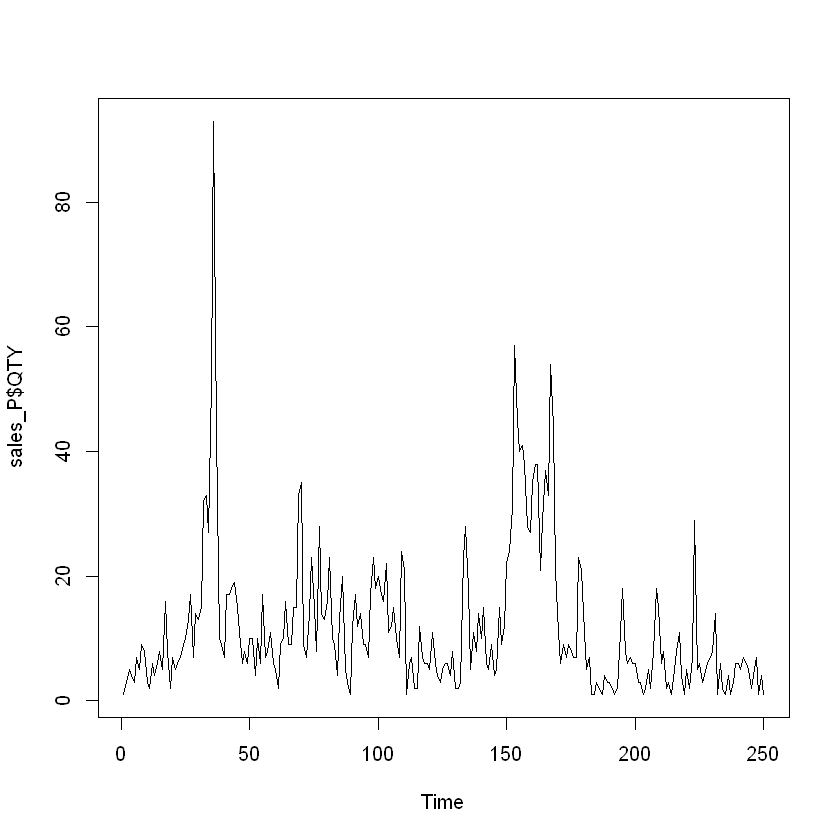

In [10]:
ts.plot(sales_P$QTY)

Comportamento da variação das vendas dia a dia (curva de vendas eliminada a tendência de longo prazo)

A grande oscilação das curvas de variação sugere um slope negativo. Também parece haver uma tendência de queda nas vendas, o que sugere um modelo tipo Random Walk

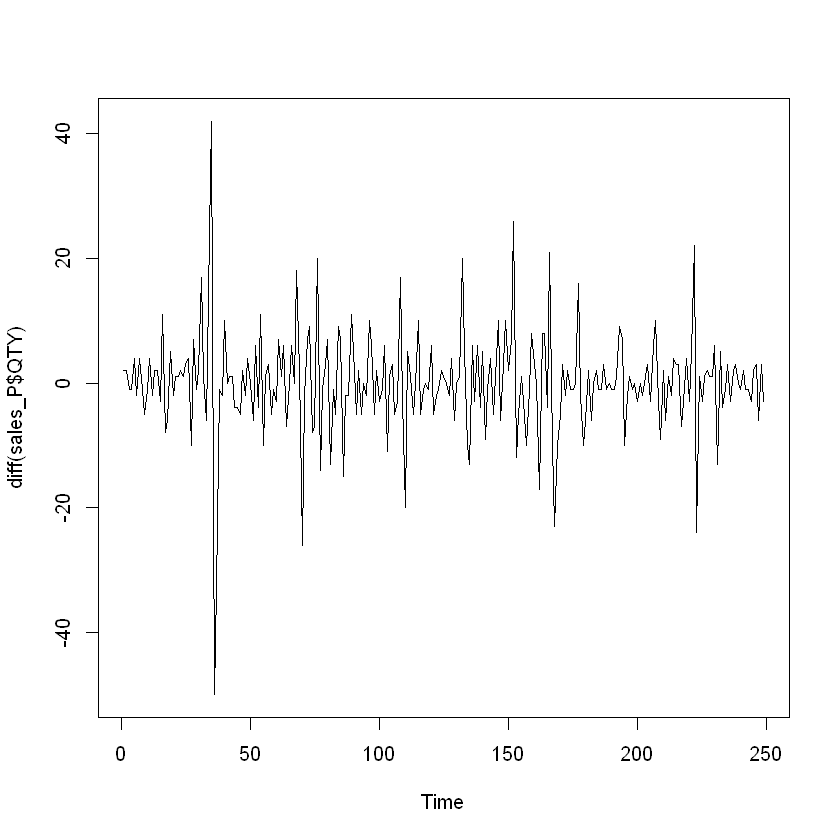

In [11]:
ts.plot(diff(sales_P$QTY))

## Análise de correlação

A correlação com o preço da concorrência já parece se mostrar um pouco mais forte

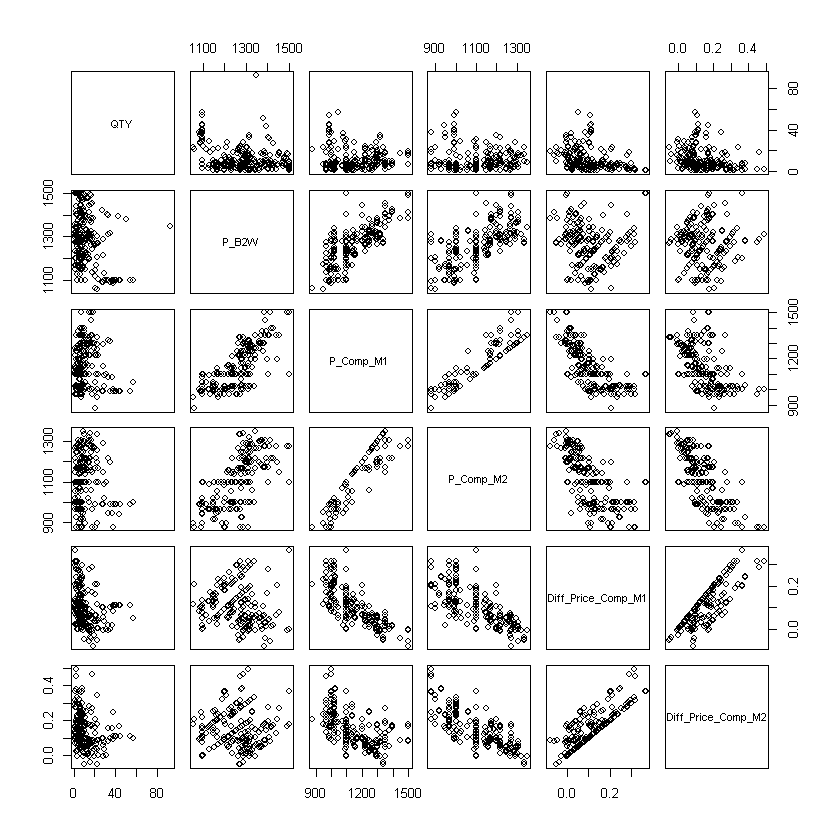

In [12]:
pairs(sales_P[,c("QTY","P_B2W","P_Comp_M1","P_Comp_M2","Diff_Price_Comp_M1","Diff_Price_Comp_M2")])

A correlação com o preço da B2W é inferior ao de P1 e P2, sendo superada pela correlação com a diferença em relação aos preços da concorrência.

In [13]:
cor(sales_P[,c("QTY","P_B2W")])
cor(na.omit(sales_P[,c("QTY","P_Comp_M1","P_Comp_M2","Diff_Price_Comp_M1","Diff_Price_Comp_M2")]))

QTY        P_B2W     
QTY    1.0000000 -0.2553237
P_B2W -0.2553237  1.0000000

QTY         P_Comp_M1   P_Comp_M2   Diff_Price_Comp_M1
QTY                 1.00000000 -0.04315356 -0.05618197 -0.3170923        
P_Comp_M1          -0.04315356  1.00000000  0.89788765 -0.7348145        
P_Comp_M2          -0.05618197  0.89788765  1.00000000 -0.6753132        
Diff_Price_Comp_M1 -0.31709231 -0.73481447 -0.67531323  1.0000000        
Diff_Price_Comp_M2 -0.28190479 -0.52310736 -0.72841991  0.8166114        
                   Diff_Price_Comp_M2
QTY                -0.2819048        
P_Comp_M1          -0.5231074        
P_Comp_M2          -0.7284199        
Diff_Price_Comp_M1  0.8166114        
Diff_Price_Comp_M2  1.0000000

## Analise de autocorrelação

O gráfico de autocorrelação mostra uma autocorrelação fortíssima, salientando um modelo de Random Walk


Autocorrelations of series 'sales_P$QTY', by lag

    0     1     2     3     4     5     6     7     8     9    10 
1.000 0.734 0.511 0.448 0.391 0.346 0.329 0.306 0.259 0.223 0.191 

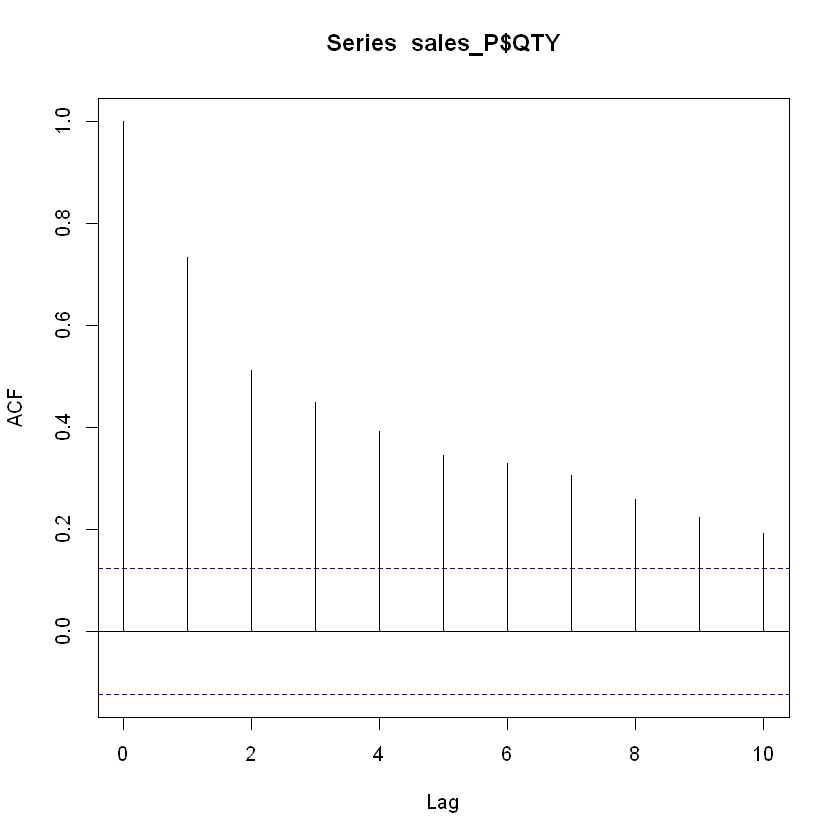

In [14]:
acf(sales_P$QTY,lag.max = 10,plot = FALSE)
acf(sales_P$QTY,lag.max = 10,plot = TRUE)

## Modelo de Autoregressão

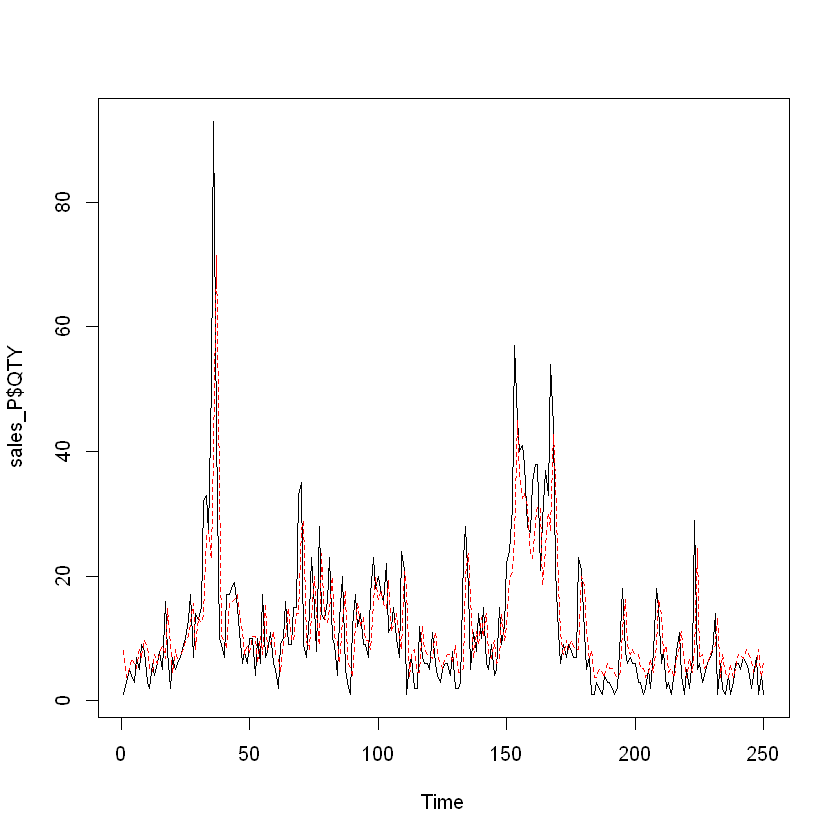

In [15]:
AR_Model<-arima(sales_P$QTY, order = c(1,0,0))
AR_fitted<-sales_P$QTY - residuals(AR_Model)
ts.plot(sales_P$QTY)
points(AR_fitted, type = "l", col = 2, lty = 2)

Realizando a previsão

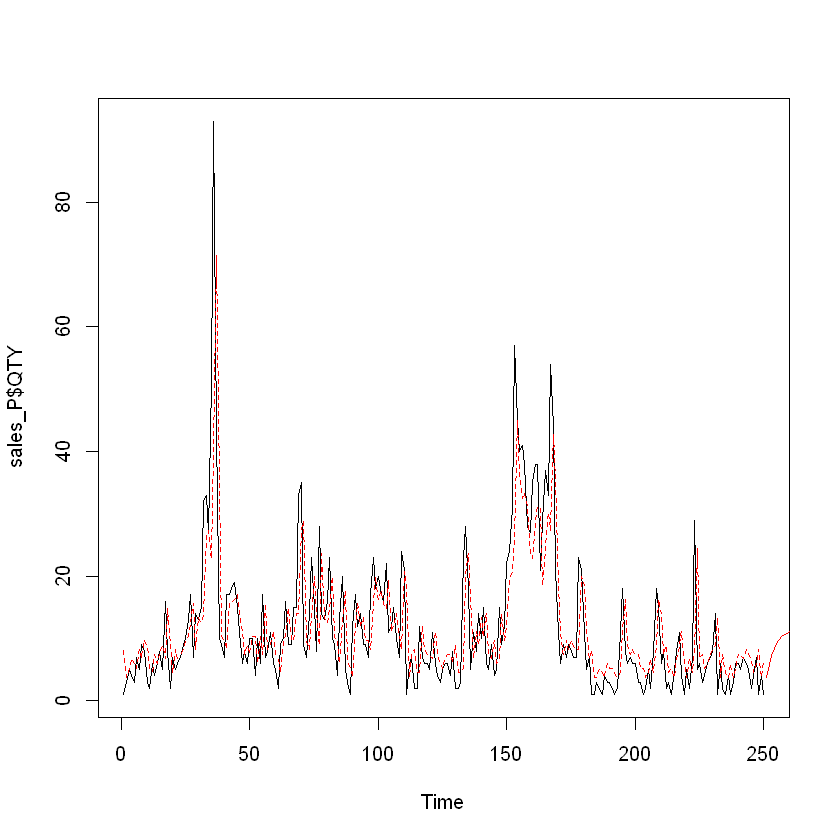

In [16]:
predict_AR<-predict(AR_Model,n.ahead = 30)
ts.plot(sales_P$QTY)
points(AR_fitted, type = "l", col = 2, lty = 2)
points(predict_AR$pred, type = "l", col = 2)

## Modelo de média móvel simples

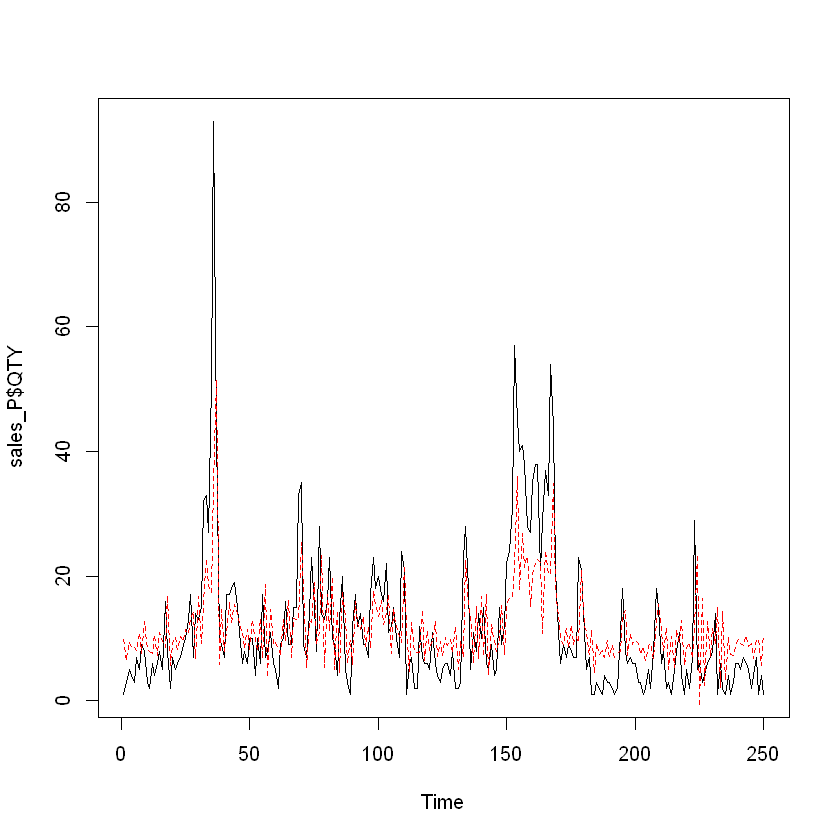

In [17]:
MA_Model<-arima(sales_P$QTY, order = c(0,0,1))
MA_fitted<-sales_P$QTY - residuals(MA_Model)
ts.plot(sales_P$QTY)
points(MA_fitted, type = "l", col = 2, lty = 2)

Realizando previsão

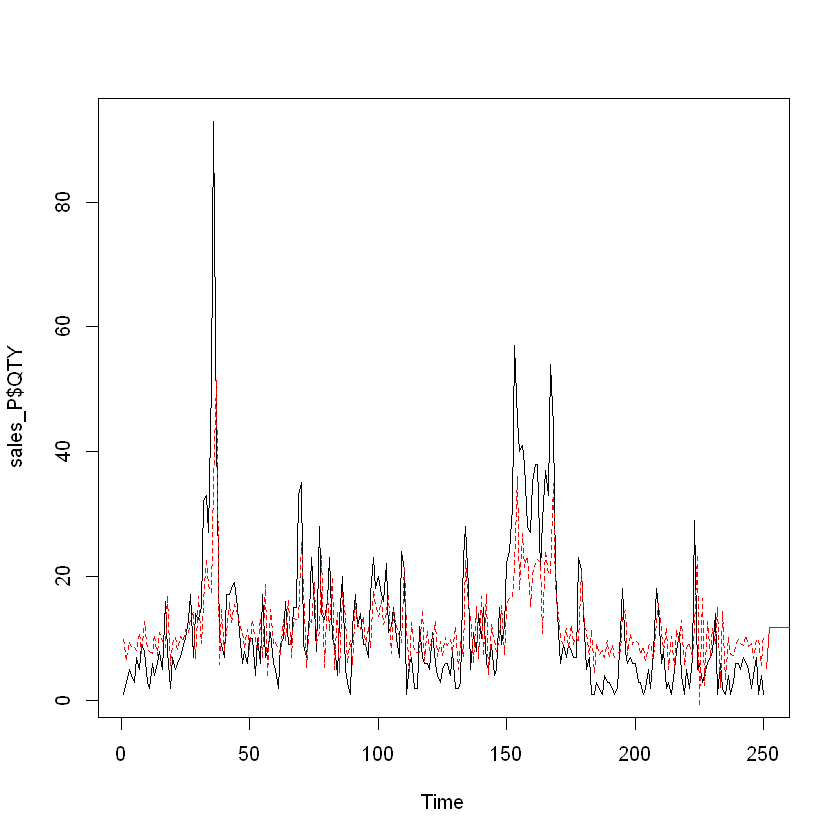

In [18]:
predict_MA<-predict(MA_Model,n.ahead = 30)
ts.plot(sales_P$QTY)
points(MA_fitted, type = "l", col = 2, lty = 2)
points(predict_MA$pred, type = "l", col = 2)

Comparando os dois modelos

O modelo de autoregressão foi superior na previsão de demanda do produto, o que faz sentido tendo em vista a alta correlação da curva de P3

In [19]:
cor(AR_fitted, MA_fitted)
paste("AIC_AR:",AIC(AR_Model))
paste("AIC_MA:",AIC(MA_Model))
paste("BIC_AR:",BIC(AR_Model))
paste("BIC_MA:",BIC(MA_Model))

[1] 0.8710938

[1] "AIC_AR: 1751.58530234299"

[1] "AIC_MA: 1797.90666678474"

[1] "BIC_AR: 1762.14968509658"

[1] "BIC_MA: 1808.47104953832"